In [180]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
import scipy.spatial.distance
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [181]:
smiley = pd.read_csv('smiley.csv', index_col = 0)
smiley.columns = ['x', 'y', 'classes']

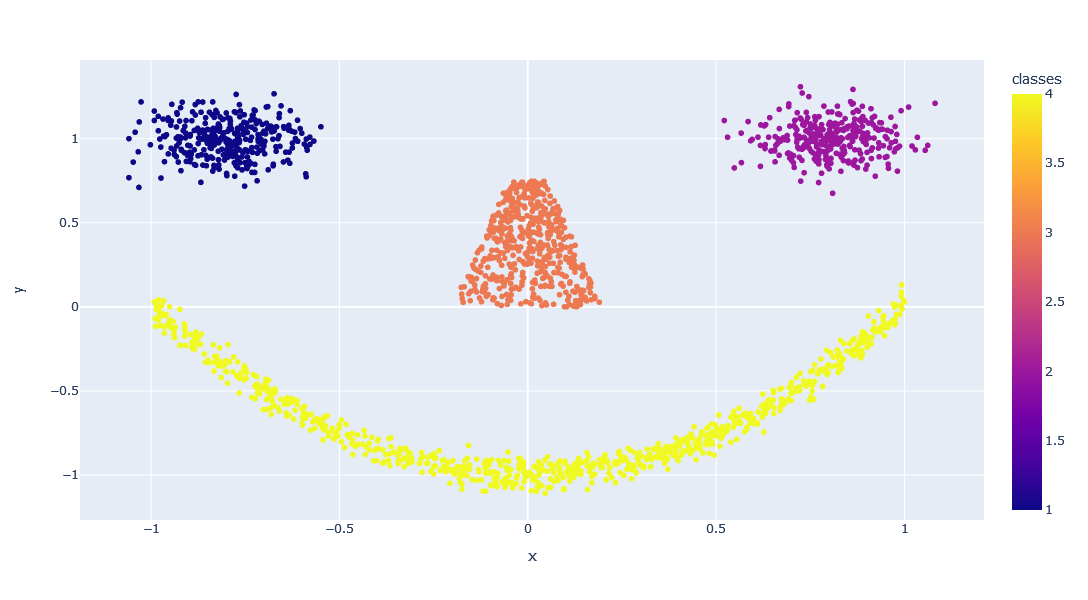

In [182]:
fig = px.scatter(smiley, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig

In [237]:
""" Sampling from each individual column then append together
 Function: can take categorical input sampling when it is NOT one-hot encoded """
def sampling(data, n, random_state):
    synth_data = pd.DataFrame()
    i = 0
    # sample column by column
    # pseudo-random
    for column in data.columns:
        synth_data[column] = data[column].sample(n = n, replace = True, random_state = random_state + i * 10).reset_index(drop = True)
        i += 1
    return synth_data

A multi-index solution may be more efficient, but much more difficult to code - look at later

In [238]:
""" Generate upper and lower bounds for all leaves given the trees of an XGBoost model
    Inspired from bnd_fn of ARF"""
def generate_bounds(trees, columns):
    upper_bounds = []
    lower_bounds = []
    for tree in trees:
        size = len(tree)
        # Define maximal upper and lower bound dataframes, progressively constrict
        upper_df = pd.DataFrame(np.ones((size, len(columns))) * np.inf, columns = columns)
        lower_df = pd.DataFrame(np.ones((size, len(columns))) * -np.inf, columns = columns)
        non_leaves = []
        # iterate through each leaf in tree, represented as rows of the df
        for index, row in tree.iterrows():
            left_child = row['Yes']
            right_child = row['No']
            feature = row['Feature']
            split = row['Split']
            parent = int(row['Node'])
            # change bounds if feature isn't a leaf
            if feature != 'Leaf':
                # get parent bounds and child ID
                parent_lower = lower_df.loc[parent]
                parent_upper = upper_df.loc[parent]
                left_child = int(left_child.split('-')[1])
                right_child = int(right_child.split('-')[1])
                # apply bounds of parents to children
                lower_df.loc[left_child] = parent_lower
                lower_df.loc[right_child] = parent_lower
                upper_df.loc[left_child] = parent_upper
                upper_df.loc[right_child] = parent_upper
                # apply split onto children
                upper_df.loc[left_child, feature] = split
                lower_df.loc[right_child, feature] = split
                non_leaves.append(parent)
        # drop non-leaf nodes
        upper_df = upper_df.drop(non_leaves)
        lower_df = lower_df.drop(non_leaves)
        upper_bounds.append(upper_df)
        lower_bounds.append(lower_df)
    return upper_bounds, lower_bounds

In [239]:
""" Encodes data using one-hot encoding and returns the locations of columns that are one-hot encoded """
def encoding(data, categorical_columns, column_information=False):
    # save the original class columns for later re-use
    data_columns = data[categorical_columns]
    #synthetic_columns = synthetic_data[categorical_columns]
    data.drop(categorical_columns, axis = 1, inplace = True)
    #synthetic_data.drop(categorical_columns, axis = 1, inplace = True)
    # do one-hot encoding on the columns, save locations
    # note that a multi-index may be more effective for this task.
    column_locations = []
    column_names = []
    for column in categorical_columns:
        encoder = OneHotEncoder(sparse = False)
        encoded_data = encoder.fit_transform(data_columns[[column]])
        #encoder = OneHotEncoder(sparse = False)
        #encoded_synthetic = encoder.fit_transform(synthetic_columns[[column]])
        column_location = []
        for i in range(encoded_data.shape[1]):
            column_location.append(data.shape[1])
            data.insert(data.shape[1], column + '_' + str(i), encoded_data[:, i])
            #synthetic_data.insert(synthetic_data.shape[1], column + '_' + str(i), encoded_synthetic[:, i])
            column_names.append(column + '_' + str(i))
        column_locations.append(column_location)
    if column_information:   
        return data, column_names, column_locations
    else:
        return data

In [240]:
""" Density estimation using a truncated MLE mixture model """
def density_estimation(booster, real_df, column_locations, column_names, distance_threshold, min_cluster_size):
    leaves = booster.predict(xgb.DMatrix(real_df), pred_leaf = True)
    tree_df = booster.trees_to_dataframe()
    # split into each idv tree
    trees_grouped = tree_df.groupby('Tree')
    trees = [trees_grouped.get_group(x).reset_index().drop('index', axis = 1) for x in trees_grouped.groups]
    upper_bounds, lower_bounds = generate_bounds(trees, real_df.columns)
    
    # clustering
    leaves_df = pd.DataFrame(leaves)
    clustering = AgglomerativeClustering(n_clusters = None, affinity = 'hamming',
                                         linkage = 'average', distance_threshold = distance_threshold)
    clustering.fit(leaves)
    leaves_df['cluster'] = clustering.labels_
    # remove small clusters
    counts = leaves_df.groupby('cluster').count()[0]
    valid_clusters = counts[counts > min_cluster_size].index
    coverage = []
    for cluster_id in valid_clusters:
        cluster = leaves_df[leaves_df['cluster'] == cluster_id]
        coverage.append(len(cluster))
    
    # MLE method, only allow valid clusters
    cluster_df = real_df
    cluster_df['cluster'] = clustering.labels_
    cluster_df = cluster_df[cluster_df['cluster'].isin(valid_clusters)]
    cluster_grouped = cluster_df.groupby('cluster')
    cluster_dfs = [cluster_grouped.get_group(x).reset_index().drop('index', axis = 1) for x in cluster_grouped.groups]
    
    # MLE parameter estimation
    mean = []
    cov = []
    min_value = []
    max_value = []
    # 3d list: [cat_var1, cat_var2, ...]
    # cat_var1: [cluster1, cluster2, ...]
    # cluster1: [pr_var_1, pr_var_2, ...]
    multinomial = [[[] for i in range(len(cluster_dfs))] for j in range(len(column_locations))]
    for i in range(0, len(cluster_dfs)):
        # get mean and covariance, min and max, MLE parameters for a truncated normal distribution
        numeric_df = cluster_dfs[i].drop(column_names, axis = 1).drop(["cluster"], axis = 1)
        mean.append(numeric_df.mean())
        cov.append(numeric_df.cov())
        min_value.append(numeric_df.min())
        max_value.append(numeric_df.max())
        cluster_size = len(cluster_dfs[i])
        # get multinomial parameters with applied Laplacian estimation
        for j in range(len(column_locations)):
            for k in range(len(column_locations[j])):
                multinomial[j][i].append((sum(cluster_dfs[i].iloc[:, column_locations[j][k]]) + 1)
                                         / (cluster_size + len(column_locations[j])))
    n_valid = len(cluster_df)
    fractions = [x/n_valid for x in coverage]
    return mean, cov, min_value, max_value, multinomial, fractions

In [241]:
""" Sampling from the parameters of density estimation """
def generative_modelling(mean, cov, min_value, max_value, 
                         multinomial, fractions, 
                         categorical_columns,
                         sample_size):
    c = len(mean)
    num_numeric = len(mean[0])
    num_classes = len(multinomial)
    samples = []
    samples_class = [[] for j in range(num_classes)]
    for i in range(sample_size):
        cluster_index = np.random.choice(c, p = fractions)
        sample_mean = mean[cluster_index]
        sample_cov = cov[cluster_index]
        # rejection sampling
        sample_min = min_value[cluster_index]
        sample_max = max_value[cluster_index]
        k = multivariate_normal.pdf(x = sample_mean, mean = sample_mean,
                                    cov = sample_cov, allow_singular = True)
        x = np.random.uniform(low = sample_min, high = sample_max, size = (1, num_numeric))
        y = np.random.uniform(low = 0, high = k, size = 1)
        while y > multivariate_normal.pdf(x = x, mean = sample_mean, cov = sample_cov):
            x = np.random.uniform(low = sample_min, high = sample_max, size = (1, num_numeric))
            y = np.random.uniform(low = 0, high = k, size = 1)
        samples.append(x)
        # sample from each categorical class
        for j in range(num_classes):
            probabilities = multinomial[j][cluster_index]
            class_label = np.random.choice(len(probabilities), p = probabilities)
            samples_class[j].append(class_label)
    samples = pd.DataFrame(np.array(samples).reshape((sample_size, num_numeric)))
    samples.columns = mean[0].index
    # put simulated data into a dataframe
    for i in range(len(categorical_columns)):
        samples[categorical_columns[i]] = samples_class[i]
    return samples

In [242]:
""" Adversarial Gradient Boosting """
def adversarial_gb(data, categorical_columns, random_state, distance_threshold=0.2, min_cluster_size=5):
    n = len(data)
    training_scores = []
    # use a copy of the data, since pd saves changes within a function to the global object
    data = data.copy()
    synthetic_data = sampling(data, n, random_state)
    # encode the synthetic and original data. only need column_names/column_locations once.
    synthetic_data = encoding(synthetic_data, categorical_columns)
    data, column_names, column_locations = encoding(data, categorical_columns, column_information=True)
    
    # make the df to be trained against and add real/synthetic labels
    data['label'] = 1
    synthetic_data['label'] = 0
    X = pd.concat((data, synthetic_data))
    X = X.reset_index().drop('index', axis = 1)
    
    # train test split on XGB
    X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :-1], X.iloc[:, -1], test_size=0.3, random_state=random_state)
    model = xgb.XGBClassifier(random_state = 1, n_estimators = 50)
    model.fit(X_train, y_train)
    training_scores.append(model.score(X_test, y_test))

    # ARF loop
    iteration = 0
    while training_scores[iteration] > 0.55 and len(training_scores) < 5:
        iteration += 1
        # get dataframe of real training samples only
        indices = y_train[y_train == 1].index
        real_df = X_train.loc[indices].reset_index().drop('index', axis = 1)
        # get model booster, leaf contributions, and tree representation
        booster = model.get_booster()
        leaves = booster.predict(xgb.DMatrix(real_df), pred_leaf = True)
        tree_df = booster.trees_to_dataframe()
        # estimate parameters of model, and sample
        mean, cov, min_value, max_value, multinomial, fractions = density_estimation(booster, real_df, 
                                                                                     column_locations, column_names,
                                                                                     distance_threshold, min_cluster_size)
        samples = generative_modelling(mean, cov, min_value, max_value,
                                       multinomial, fractions,
                                       categorical_columns,
                                       n)
        # re-encode new synthetic data
        synthetic_data = samples.copy()
        synthetic_data = encoding(synthetic_data, categorical_columns)
        
        synthetic_data['label'] = 0
        X = pd.concat((data, synthetic_data))
        X = X.reset_index().drop('index', axis = 1)
    
        # new train test split on XGB
        X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :-1], X.iloc[:, -1], test_size=0.3, random_state=random_state)
        model = xgb.XGBClassifier(random_state = 1, n_estimators = 50)
        model.fit(X_train, y_train)
        training_scores.append(model.score(X_test, y_test))
    return samples

In [243]:
out_df = adversarial_gb(smiley, ['classes'], 30025, 0.2, 6)

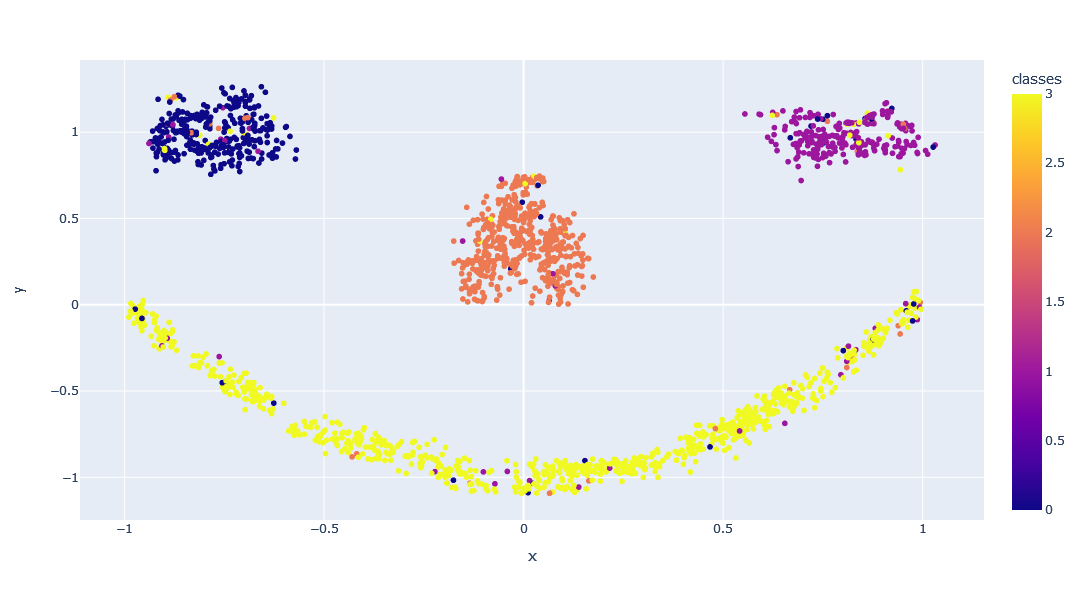

In [244]:
fig = px.scatter(out_df, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig